In [1]:
import scipy.io
import os
import shutil
try:
    from urllib import urlretrieve # python2
except:
    from urllib.request import urlretrieve # python3
import loss_csa as CSA
from torchmetrics import SpectralAngleMapper

In [2]:
import data as data
import numpy as np
import matplotlib.pyplot as plt
import torch as T
import torch
device = T.device("cuda")  # apply to Tensor or Module
import time
from tqdm import tqdm
from train_objectives import SAD, SID

In [3]:
torch.cuda.empty_cache()

In [4]:
mat = scipy.io.loadmat( 'PaviaU.mat' )
img = mat[ 'paviaU' ]

# create a hyperspectral dataset object from the numpy array
hypData = data.HypImg( img )

# pre-process data to make the model easier to train
hypData.pre_process( 'minmax' )

In [5]:
# create data iterator objects for training and validation using the pre-processed data
trainSamples = 200000
valSamples = 100
dataTrain = data.Iterator( dataSamples=hypData.spectraPrep[:trainSamples, :],
                        targets=hypData.spectraPrep[:trainSamples, :], batchSize=4 )
dataVal = data.Iterator( dataSamples=hypData.spectraPrep[trainSamples:trainSamples+valSamples, :],
                        targets=hypData.spectraPrep[trainSamples:trainSamples+valSamples, :] )


In [6]:
# shuffle training data
dataTrain.shuffle()

In [7]:
train_data = torch.tensor(dataTrain.dataSamples.astype(np.float32))
train_data

tensor([[4.4189e-07, 8.7937e-02, 9.2798e-02,  ..., 3.3805e-01, 3.2656e-01,
         3.2479e-01],
        [2.0400e-02, 4.1632e-07, 5.2040e-02,  ..., 7.5562e-01, 7.7269e-01,
         7.8185e-01],
        [2.9957e-01, 2.2673e-01, 2.1611e-01,  ..., 8.0463e-01, 8.1187e-01,
         8.2489e-01],
        ...,
        [1.0440e-01, 1.2919e-01, 1.3059e-01,  ..., 8.0028e-01, 8.0587e-01,
         8.1460e-01],
        [7.1619e-02, 7.7184e-02, 7.6458e-02,  ..., 8.9548e-01, 8.8967e-01,
         9.0515e-01],
        [3.6724e-07, 1.1789e-01, 2.0639e-01,  ..., 8.8726e-01, 8.8542e-01,
         8.8689e-01]])

In [8]:
hypData.numBands
encoderSize=[50,30,10]
encoderSize=[hypData.numBands]+encoderSize
decodersize=encoderSize[::-1]
encoderSize,decodersize

([103, 50, 30, 10], [10, 30, 50, 103])

In [9]:
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))

In [10]:
# -----------------------------------------------------------

class Net(T.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.enn1 = T.nn.Linear(103, 50)  # 64-16-2-16-64
    self.enn2 = T.nn.Linear(50, 30)
    self.enn3 = T.nn.Linear(30,10)
    self.dnn3 = T.nn.Linear(10, 30)  # 64-16-2-16-64
    self.dnn2 = T.nn.Linear(30, 50)
    self.dnn1 = T.nn.Linear(50,103)

  def encoder(self,x):
    z= T.relu(self.enn1(x))
    z= T.relu(self.enn2(z))
    z= T.relu(self.enn3(z))
    return z
  
  def decoder(self,x):
    z= T.relu(self.dnn3(x))
    z= T.relu(self.dnn2(z))
    z= self.dnn1(z)
    return z


  def forward(self, x):
    encoded=self.encoder(x)
    decoded= self.decoder(encoded)
    
    return encoded,decoded
    
net=Net().to(device)


In [11]:

inpu=torch.rand(1,103).to(device)
outp=net(inpu)
outp[1].shape


torch.Size([1, 103])

In [12]:
hypData.numBands

103

In [29]:
# -----------------------------------------------------------

force_cudnn_initialization()
# 0. setup
print("\nBegin UCI digits auto-reduce-viz demo job ")
T.manual_seed(1)
np.random.seed(1)

bat_size = 8184
train_ldr = T.utils.data.DataLoader(train_data,
batch_size=bat_size, shuffle=True)
  # 2. create network
print("\nCreating 64-16-2-16-63 autoencoder ")
net = Net().to("cuda:0")

# 3. train model
max_epochs = 1000
ep_log_interval = 5
lrn_rate = 0.0001

loss_func1 = T.nn.MSELoss()
loss_func = CSA()
optimizer = T.optim.Adam(net.parameters(), lr=lrn_rate)

print("\nbat_size = %3d " % bat_size)
print("loss = " + str(loss_func))
print("optimizer = Adam")
print("max_epochs = %3d " % max_epochs)
print("lrn_rate = %0.3f " % lrn_rate)

print("\nStarting training")
net = net.train()


for epoch in range(0, max_epochs):
  time.sleep(0.5)
  loop= tqdm(enumerate(train_ldr), total=len(train_ldr),leave=True)
  epoch_loss = 0  # for one full epoch
  mseloss=0

  iterator = iter(train_ldr)
  
  for (batch_idx, batch) in loop:
    Z = next(iterator)
    Z = Z.view(Z.size()[0], -1)
    Z = Z.cuda()
    
    enc_out, dec_out = net(Z.float())
    loss1 = loss_func(dec_out, Z.float())  
    loss1 = torch.sum(loss1).float()
    optimizer.zero_grad()
    loss1.backward()
    optimizer.step()
    
    X = batch.to(device)  # no targets needed
    
    '''optimizer.zero_grad()
    oupt = net(X)
    loss_obj = loss_func(oupt[1], X)  # note: X not Y'''
    #loss_obj1=loss_func1(oupt[1],X)
    epoch_loss += loss1.item()  # accumulate
    #mseloss+=loss_obj1.item()
    #loss_obj.backward()
    #optimizer.step()
    
    loop.set_description(f"Epoch [{epoch}/{max_epochs}]")
    loop.set_postfix(loss=str(epoch_loss))

    

  #if epoch % ep_log_interval == 0:
    
    
    #print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss)) 
print("Done ")

# 4. plot digits using reduced form
print("\nCreating graph from encoded data ")
net = net.eval()






Begin UCI digits auto-reduce-viz demo job 

Creating 64-16-2-16-63 autoencoder 


TypeError: 'module' object is not callable

In [ ]:
p=net(Z.float())
p.detach()

In [ ]:

torch.save(net, 'model_csa.pth')

In [ ]:
torch.save(net.state_dict(), 'net_model_csa.pth')

In [15]:
net.load_state_dict(torch.load('net_model_csa1.pth'))

<All keys matched successfully>

In [16]:
trex=torch.tensor(hypData.spectraPrep.astype(np.float32))
trex

tensor([[0.1428, 0.1011, 0.0913,  ..., 0.8679, 0.8727, 0.8761],
        [0.1670, 0.1465, 0.1398,  ..., 0.8144, 0.8221, 0.8447],
        [0.2236, 0.2766, 0.1961,  ..., 0.9382, 0.9538, 0.9606],
        ...,
        [0.1139, 0.0292, 0.0460,  ..., 0.8492, 0.8594, 0.8660],
        [0.1068, 0.1744, 0.1333,  ..., 0.8415, 0.8397, 0.8316],
        [0.2278, 0.1603, 0.0520,  ..., 0.8381, 0.8505, 0.8657]])

In [17]:
dataZ=net.encoder(trex.to("cuda"))
dataZ

tensor([[0.6252, 0.0000, 0.0000,  ..., 0.1523, 0.0000, 1.0348],
        [0.6859, 0.0000, 0.0000,  ..., 0.1980, 0.0000, 1.0999],
        [0.6870, 0.0000, 0.0000,  ..., 0.2340, 0.0000, 1.0933],
        ...,
        [0.6177, 0.0000, 0.0000,  ..., 0.2201, 0.0000, 1.1995],
        [0.6340, 0.0000, 0.0000,  ..., 0.2503, 0.0000, 1.1827],
        [0.5969, 0.0000, 0.0000,  ..., 0.2286, 0.0000, 1.1493]],
       device='cuda:0', grad_fn=<ReluBackward0>)

In [18]:
dataY = net.decoder(dataZ)
dataY

tensor([[0.0031, 0.0036, 0.0054,  ..., 0.0917, 0.0448, 0.1098],
        [0.0039, 0.0045, 0.0080,  ..., 0.0905, 0.0439, 0.1085],
        [0.0066, 0.0075, 0.0108,  ..., 0.0917, 0.0443, 0.1093],
        ...,
        [0.0017, 0.0017, 0.0031,  ..., 0.0902, 0.0435, 0.1089],
        [0.0039, 0.0044, 0.0067,  ..., 0.0910, 0.0438, 0.1094],
        [0.0048, 0.0050, 0.0046,  ..., 0.0920, 0.0445, 0.1102]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [64]:
imgZ = np.reshape(dataZ.to("cpu").detach().numpy(), (hypData.numRows, hypData.numCols, -1))

In [65]:
imgY = np.reshape(dataY.to("cpu").detach().numpy(), (hypData.numRows, hypData.numCols, -1))

In [66]:
imgX = np.reshape(hypData.spectraPrep, (hypData.numRows, hypData.numCols, -1))

In [67]:
# visualise latent image using 3 out of the 10 dimensions
colourImg = imgZ.copy()
colourImg = colourImg[ :,:,np.argsort(-np.std(np.std(colourImg, axis=0), axis=0))[:3] ]
colourImg /= np.max(np.max(colourImg, axis=0), axis=0)

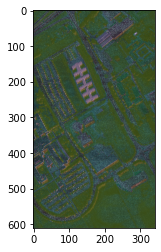

In [68]:
plt.imshow(colourImg)

Text(0.5, 1.0, 'meadow spectra')

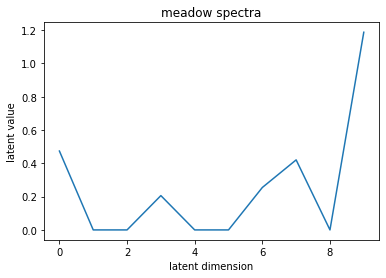

In [69]:
# save plot of latent vector of 'meadow' spectra
fig = plt.figure()
plt.plot(imgZ[576, 210, :])
plt.xlabel('latent dimension')
plt.ylabel('latent value')
plt.title('meadow spectra')

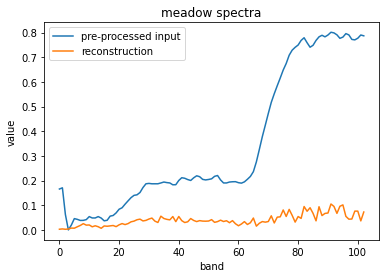

In [70]:
# save plot comparing pre-processed 'meadow' spectra input with decoder reconstruction
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range(hypData.numBands),imgX[576, 210, :],label='pre-processed input')
ax.plot(range(hypData.numBands),imgY[576, 210, :],label='reconstruction')
plt.xlabel('band')
plt.ylabel('value')
plt.title('meadow spectra')
ax.legend()

In [58]:

inpt1=torch.rand(3,103)
inpt2=torch.rand(3,103)
outp=csa(inpt1,inpt2)
outp

tensor(-33.1632)

In [59]:
input=Z
target=dec_out
eps=1e5

normalize_inp = (input/torch.sum(input, dim=0)) + eps
normalize_tar = (target/torch.sum(target, dim=0)) + eps
sid = torch.sum(normalize_inp * torch.log(normalize_inp / normalize_tar) + normalize_tar * torch.log(normalize_tar / normalize_inp))
sid

tensor(0., device='cuda:0', grad_fn=<SumBackward0>)

In [60]:
decout = dec_out.detach()
decout.shape

torch.Size([3584, 103])

In [17]:
def csa1(input, target):
    norm_r = torch.nn.functional.normalize(torch.transpose(input,0,0),dim=0)
    norm_t = torch.nn.functional.normalize(torch.transpose(target,0,0),dim=0)
    mult = torch.multiply(norm_r,norm_t).sum()
    return 1-mult.sum()

In [37]:
def csa(input, target):
    normalize_r = (input/torch.sum(input, dim=0)) 
    normalize_t = (target/torch.sum(target, dim=0))
    mult = torch.multiply(normalize_r,normalize_t).sum()
    return 1-mult.sum()

In [ ]:
normalize_r = (input/torch.sum(input, dim=0)) 
normalize_t = (target/torch.sum(target, dim=0))
mult = torch.multiply(normalize_r,normalize_t).sum()
1-mult

In [ ]:
csaloss = torch.acos(mult)
csaloss

In [14]:
def csam(input, target):
    normalize_r = (input/torch.sum(input, dim=0)) 
    normalize_t = (target/torch.sum(target, dim=0))
    mult = torch.sum(torch.multiply(normalize_r,normalize_t),dim=0)
    mult = 1-(torch.sum(mult))
    return mult